<a href="https://colab.research.google.com/github/margaret-tk/APS360-AI/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [0]:
import numpy as np
import torch
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# location on Google Drive
master_path = '/content/drive/My Drive/'

classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

data_transform = transforms.Compose([transforms.RandomResizedCrop(64), 
                                      transforms.ToTensor()])

dataset = datasets.ImageFolder(master_path+'dataset/imgs', transform=data_transform)
subset = datasets.ImageFolder(master_path+'aps360_subset', transform=data_transform)

In [0]:
len(dataset)
#train_index+ val_index+ test_index+ extra_index
import pandas as pd
pd_dataset = pd.Series(dataset.targets)
pd_dataset.value_counts()

2    3004
9    3000
7    3000
1    3000
0    3000
8    2500
6    2500
4    2500
3    2500
5    2000
dtype: int64

In [0]:
#train_index, val_index, test_index = int(0.6*len(subset)), int(0.2*len(subset)), int(0.2*len(subset))
#train, val, test = torch.utils.data.random_split(subset, [train_index,val_index,test_index])

In [0]:
train_index, val_index, test_index, extra = int(0.05*len(dataset)), int(0.01*len(dataset)), int(0.01*len(dataset)), int(0.93*len(dataset))+1
train, val, test, extra = torch.utils.data.random_split(dataset, [train_index,val_index,test_index, extra])

In [0]:
#train_index, test_index = int(0.7*len(dataset))+1, int(0.3*len(dataset))
#train, test = torch.utils.data.random_split(dataset, [train_index,test_index])

In [0]:
len(train_loader.dataset)

1350

In [0]:
# define dataloader parameters
batch_size  = 20
num_workers = 1

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=7000, 
                                           num_workers=num_workers, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, 
       #                                    num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=3000, 
                                           num_workers=num_workers, shuffle=True)

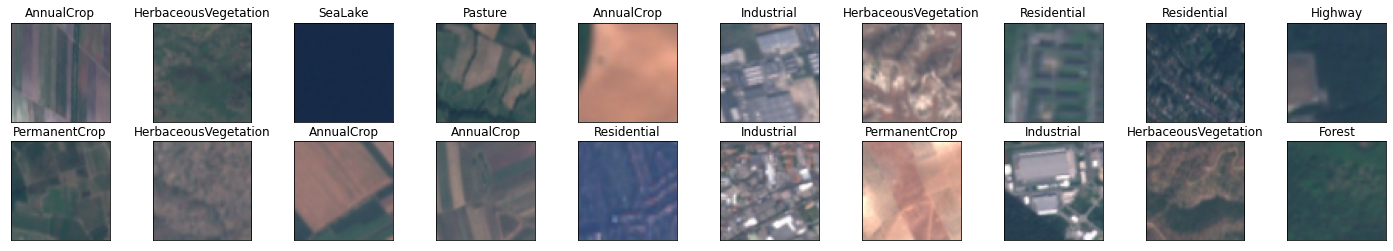

In [0]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 
# convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [0]:
torch.manual_seed(1)

dataiter = iter(train_loader)
images, labels = dataiter.next()

model = models.alexnet(pretrained=True)
#inception = models.inception.inception_v3(pretrained=True)
#resNet18 = models.resnet.resnet18(pretrained=True)
#resNet152 = models.resnet.resnet152(pretrained=False)


features = alexNet.features(images)
features.shape

torch.Size([1350, 256, 1, 1])

In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
n_classes = 10
n_inputs = model.classifier[6].in_features


In [0]:
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): LogSoftmax()
  )
)

In [0]:
len(train_loader.dataset)

1350

In [0]:

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

58,055,242 total parameters.
1,051,402 training parameters.


In [0]:
def get_pretrained_model(model_name):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    

    return model

In [0]:

model = get_pretrained_model('vgg16')


In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [0]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


In [0]:
from timeit import default_timer as timer

In [0]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          #save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            #if train_on_gpu:
                #data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    #if train_on_gpu:
                        #data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    #torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        #model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [0]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2)

Model has been trained for: 1 epochs.


Epoch: 1 	Training Loss: 1.2147 	Validation Loss: 1.1817
		Training Accuracy: 60.96%	 Validation Accuracy: 58.89%

Epoch: 3 	Training Loss: 1.0572 	Validation Loss: 1.0316
		Training Accuracy: 64.30%	 Validation Accuracy: 63.70%

Epoch: 5 	Training Loss: 0.9519 	Validation Loss: 1.0170
		Training Accuracy: 68.44%	 Validation Accuracy: 62.59%

Epoch: 7 	Training Loss: 0.8738 	Validation Loss: 0.9513
		Training Accuracy: 70.07%	 Validation Accuracy: 67.78%

Epoch: 9 	Training Loss: 0.8349 	Validation Loss: 0.9287
		Training Accuracy: 71.04%	 Validation Accuracy: 67.41%

Epoch: 11 	Training Loss: 0.7954 	Validation Loss: 0.9220
		Training Accuracy: 72.22%	 Validation Accuracy: 68.89%

Epoch: 13 	Training Loss: 0.7708 	Validation Loss: 0.9630
		Training Accuracy: 73.63%	 Validation Accuracy: 63.70%

Epoch: 15 	Training Loss: 0.7778 	Validation Loss: 0.9494
		Training Accuracy: 74.30%	 Validation Accuracy: 68.15%

Epoch: 17 	Training Loss: 0.7223 	Val

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

Text(0.5, 1.0, 'Training and Validation Losses')

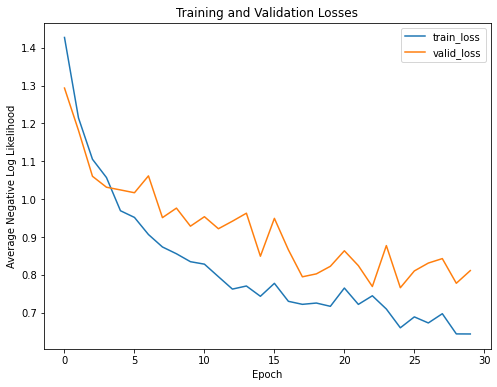

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

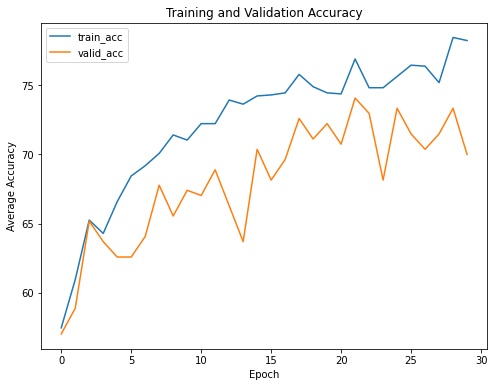

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [0]:
def get_random_images(num):
    torch.manual_seed(0)
    data = datasets.ImageFolder(master_path+'dataset/imgs', transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()

    return images, labels

In [0]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor
    #input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [0]:
test_transforms = transforms.Compose([transforms.Resize(64),
                                      transforms.ToTensor(),
                                     ])

###**DEMO**


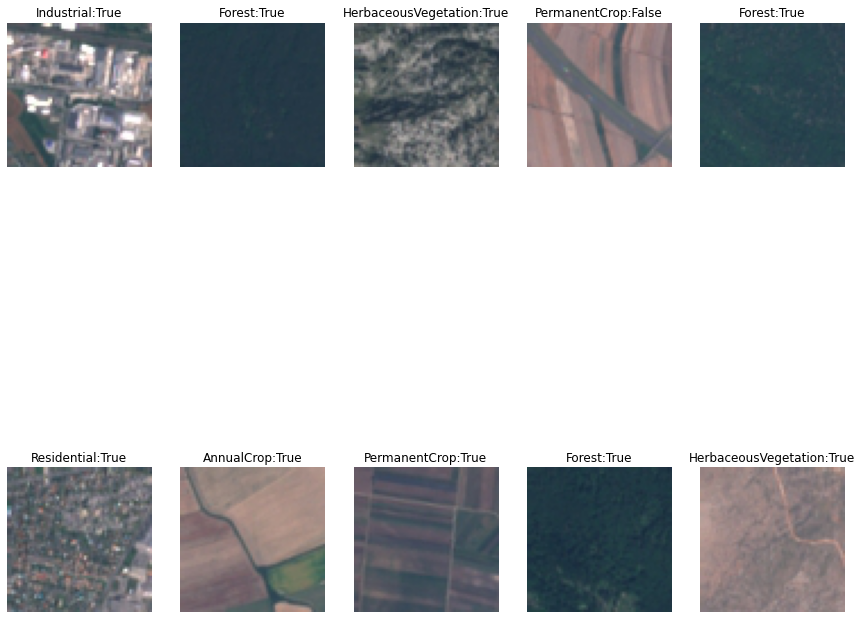

In [0]:
from PIL import Image

to_pil = transforms.ToPILImage()
images, labels = get_random_images(10)
fig=plt.figure(figsize=(15,15))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(2, len(images)/2, ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

 

### **Cont.** 

In [0]:
images, labels = get_random_images(10)
to_pil = transforms.ToPILImage()
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    res = int(labels[ii]) == index
    print("Image is ", str(classes[labels[ii]]), 'predicted ', str(classes[index]),  'This is ' , str(res) )
    
    #sub.set_title(str(classes[index]) + ":" + str(res))
    #plt.axis('off')
    #plt.imshow(image)

Image is  River predicted  Highway This is  False
Image is  River predicted  River This is  True
Image is  Pasture predicted  PermanentCrop This is  False
Image is  Residential predicted  Residential This is  True
Image is  SeaLake predicted  SeaLake This is  True
Image is  Residential predicted  Residential This is  True
Image is  Forest predicted  Forest This is  True
Image is  HerbaceousVegetation predicted  Forest This is  False
Image is  Pasture predicted  Forest This is  False
Image is  SeaLake predicted  SeaLake This is  True


In [0]:
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
heat = pd.DataFrame(columns = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 
                               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'])

for cover in classes:
  heat = heat.append({'Real':cover,'AnnualCrop':0, 'Forest':0, 'HerbaceousVegetation':0, 'Highway':0, 
                      'Industrial':0, 'Pasture':0, 'PermanentCrop':0, 'Residential':0, 'River':0, 'SeaLake':0}, ignore_index = True)
  
heat.set_index('Real', inplace = True)

heat = heat.apply(pd.to_numeric, errors='coerce')

to_pil = transforms.ToPILImage()
images, labels = get_random_images(1000)

for i in range(1000):
  image = to_pil(images[i])
  pred = classes[predict_image(image)]
  real = classes[labels[i]]

  #print(image, real, pred)

  heat.at[real,pred] = heat.at[real,pred] + 1




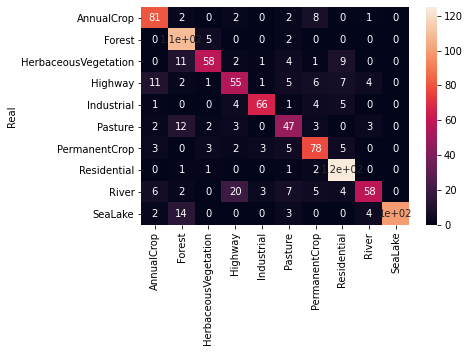

In [0]:
sns.heatmap(heat, annot=True)
